## Define Function and its Symmetry

In [21]:
import random

import torch
import matplotlib.pyplot as plt

from constants import TICK_SIZE, LABEL_FONT_SIZE, FIG_HEIGHT, DPI

plt.rcParams.update({
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'legend.fontsize': LABEL_FONT_SIZE
})

n_features = 2
LAMBDA = 1
RHO = 1
DTYPE = torch.float32
SYMMETRY_DIM = 1
cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=DTYPE)

def f(state, cost_matrix=cost_matrix):
    """Evaluates f for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

## Generate Dataset

In [2]:
N_SAMPLES = 100_000
s = torch.randn(N_SAMPLES, n_features, dtype=DTYPE)
y = f(s)

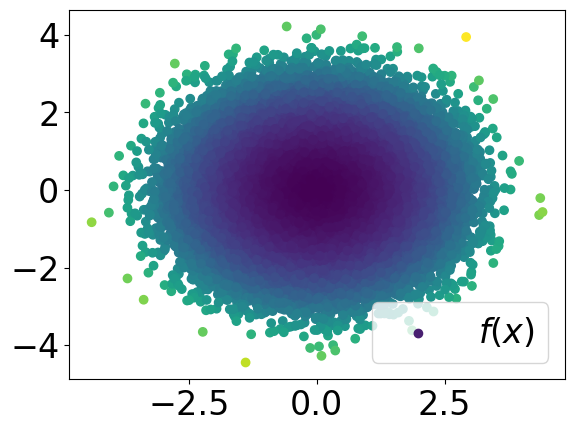

In [24]:
import matplotlib.pyplot as plt

plt.scatter(s.numpy()[:,0], s.numpy()[:,1], c=y.numpy(), label="$f(x)$")
plt.legend()
plt.show()

## Differential Symmetry Discovery

### Step 1: Learn Basis of Kernel at each Point

In [3]:
from scipy.spatial import KDTree
import numpy as np
from typing import Tuple, Dict

EPSILON_BALL = 0.05
EPSILON_LEVEL_SET = 0.005

def compute_neighborhood(data, epsilon) -> list:
    """Computes the neighborhood of each point in data.
    Args:
        data: torch.Tensor of shape (n_samples, n_features)
        epsilon: float"

    Returns:
        list of lists of integers, where the ith element is the list of indices of the neighbors of the ith point in data.
    """
    tree = KDTree(data.numpy())
    return tree.query_ball_tree(tree, epsilon)

def compute_kernel_samples(x_values, y_values, epsilon_ball, epsilon_level_set) -> Tuple[Dict, Dict]:
    """
    Computes a pointwise approximation of samples from the kernel of $f$.

    Args:
        neighbors: list of lists of integers, where the ith element is the list of indices of the neighbors of the ith point in data.
        y_values: torch.Tensor of shape (n_samples,), the readout of f at each point in data.
        epsilon_level_set: float, tolerance level for the level set.

    Returns:
        local_level_set: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_neighbors,) containing the indices of the neighbors that belong to the same level set
        kernel_vectors: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_kernel_vectors, n_features) containing a sample from the kernel distribution
    """
    neighbors = compute_neighborhood(x_values, epsilon_ball)

    # a) Approximate which samples are (i) close to a given sample and (ii) belong to the same level.
    local_level_set = {}
    for idx, y in enumerate(y_values):

        x_neighbors_idxs = np.array(neighbors[idx])
        x_neighbors_idxs = x_neighbors_idxs[x_neighbors_idxs != idx] #remove the point itself

        x_neighbors_level_set_membership = np.array(torch.abs(y_values[x_neighbors_idxs] - y) < epsilon_level_set)
        x_neighbors_level_set_idxs = x_neighbors_idxs[x_neighbors_level_set_membership]

        local_level_set[idx] = x_neighbors_level_set_idxs

    # b) Approximate the exponential map between samples in the same level set and in an \epsilon-ball via a linear approximation.
    kernel_vectors = {}
    for idx_sample, sample in enumerate(x_values):
        kernel_vectors[idx_sample] = torch.zeros((len(local_level_set[idx_sample]), n_features), dtype=DTYPE)

        for idx, neighbor_idx in enumerate(local_level_set[idx_sample]):
            kernel_vectors[idx_sample][idx] = x_values[neighbor_idx] - sample

    return kernel_vectors, local_level_set, neighbors


def compute_pointwise_basis(kernel_vectors: dict[int, torch.tensor], local_level_set: dict[int, torch.tensor]) -> dict[int, torch.tensor]:
    """
    Computes a 1-D pointwise basis of the kernel distribution at each sample if there exists at least one non-trivial tangent vector in the kernel.

    Args:
        kernel_vectors: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_kernel_vectors, n_features) containing a sample from the kernel distribution

    Returns:
        basis: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_kernel_vectors, n_features) containing a basis of the kernel distribution at the
    """
    basis = {}
    for idx_sample in kernel_vectors.keys():

        # idxs_points_in_local_level_set = list(local_level_set[idx_sample])
        # kernel_vectors_point = torch.empty(size=(0, n_features), dtype=DTYPE)
        # for idx_point in idxs_points_in_local_level_set:
        #     kernel_vectors_point = torch.vstack((kernel_vectors_point, kernel_vectors[idx_point]))
        kernel_vectors_point = kernel_vectors[idx_sample]
        if len(kernel_vectors_point) == 0:
            # No non-trivial tangent vectors known in the kernel so we can't compute a basis.
            continue
        elif len(kernel_vectors_point) == 1:
            # Only one non-trivial kernel vector, use this as approximation of the kernel at p.
            basis[idx_sample] = torch.nn.functional.normalize(kernel_vectors_point, p=2, dim=1).flatten()
        else:
            # There exists at least two non-trivial kernel vectors, compute a basis of dimension SYMMETRY_DIM of the Kernel distribution at the sample, normalized to have unit norm.
            # TODO, there is even in the 1-D case an identification problem here as the basis vector can point in two directions.
            _, _, _basis_vector = torch.pca_lowrank(kernel_vectors_point, q=SYMMETRY_DIM)
            _basis_vector = _basis_vector.T # PCA returns a vector of shape (1, n_features), we want it to be of shape (n_features, 1)
            basis[idx_sample] = torch.nn.functional.normalize(_basis_vector, p=2, dim=1).flatten()

    return basis

kernel, local_level_set, neighbors = compute_kernel_samples(s, y, EPSILON_BALL, EPSILON_LEVEL_SET)
basis = compute_pointwise_basis(kernel, local_level_set)



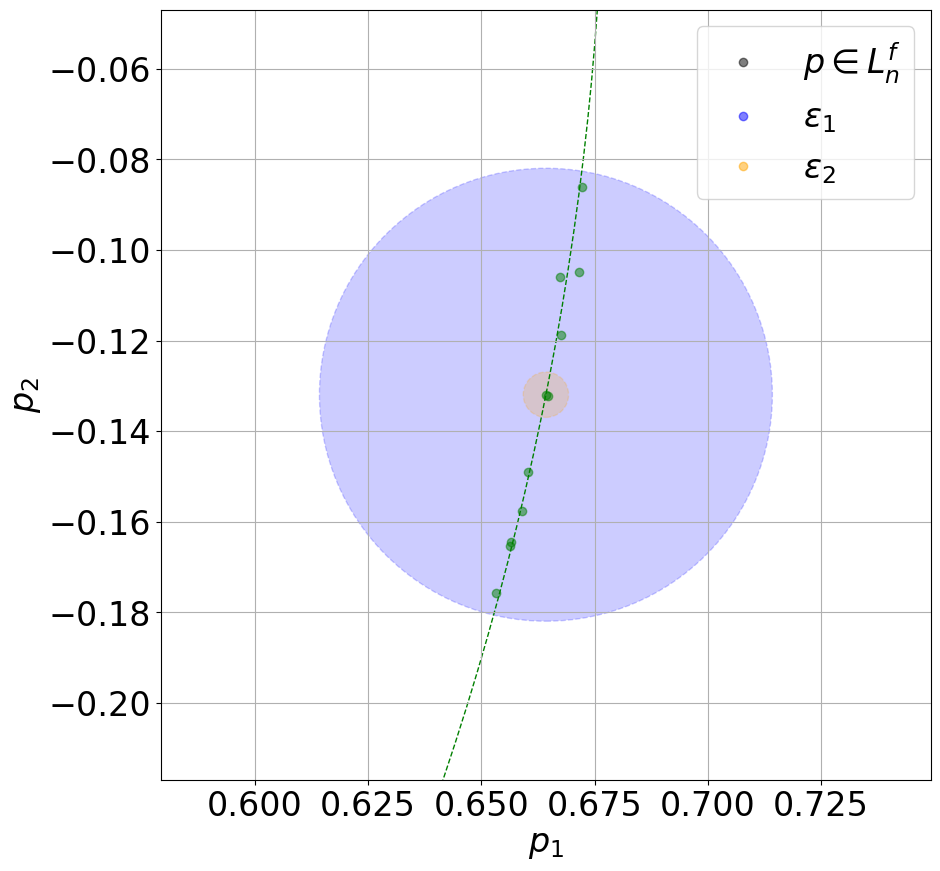

In [148]:
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

idx_point = 67

plot_lims = 0.085
SCALE_TANGENT_VECTOR = 0.03

def plot_point_level_set_tangent(idx_points: list[int],
                                 save_fig: bool = False,
                                 plot_balls: bool = False,
                                 plot_kernel: bool=False):
    colors = ['g', 'b', 'm', 'c']
    directions = [1, -1]

    # Get point coordinates before plotting to compute width
    p = s[idx_points[0]]
    p_x, p_y = p[0], p[1]
    x_min, x_max = p_x - plot_lims, p_x + plot_lims
    y_min, y_max = p_y - plot_lims, p_y + plot_lims

    # Compute aspect ratio and width
    aspect_ratio = (x_max - x_min) / (y_max - y_min)
    fig_width = FIG_HEIGHT * aspect_ratio

    fig, ax = plt.subplots(figsize=(fig_width, FIG_HEIGHT))

    for idx, idx_point in enumerate(idx_points):
        direction = idx % 2

        if plot_balls:
            circle = patches.Circle((p_x, p_y), EPSILON_BALL, fill=True, linestyle='--', linewidth=1, color="blue", alpha=0.2, label="$\epsilon_1$")
            ax.add_patch(circle)

            circle = patches.Circle((p_x, p_y), EPSILON_LEVEL_SET, fill=True, linestyle='--', linewidth=1, color="orange", alpha=0.2, label="$\epsilon_2$")
            ax.add_patch(circle)

        p = s[idx_point]
        p_x = p[0]
        p_y = p[1]

        ax.scatter(s[local_level_set[idx_point]][:, 0], s[local_level_set[idx_point]][:, 1], c=colors[idx], alpha=0.5)
        ax.scatter(p_x, p_y, c=colors[idx], alpha=0.5)

        if plot_kernel:
            _basis_vector = basis[idx_point].numpy().flatten() * SCALE_TANGENT_VECTOR * directions[direction]
            ax.quiver(p_x, p_y, _basis_vector[0], _basis_vector[1], angles='xy', scale_units='xy', color=colors[idx], scale=1)

        circle_radius = s[idx_point].norm()
        circle = patches.Circle((0, 0), circle_radius, fill=False, linestyle='--', linewidth=1, edgecolor=colors[idx])
        ax.add_patch(circle)
        ax.set_aspect('equal')



    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    legend_elements = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', label=r'$p \in L^{f}_{n}$', alpha=0.5),
    ]
    if plot_kernel:
        legend_elements += [
        mlines.Line2D([0], [0], color='black', marker='>', linestyle='-', markersize=8,
                  label=r'$D^f_p$', linewidth=2, markevery=(1,)),        
        mlines.Line2D([], [], color='black', linestyle='--', label='Level Set')
        ]

    if plot_balls:
        legend_elements += [
            mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='$\epsilon_1$', alpha=0.5),
            mlines.Line2D([], [], color='orange', marker='o', linestyle='None', label='$\epsilon_2$', alpha=0.5),
            ]

    ax.legend(handles=legend_elements)
    ax.set_xlabel(r'$p_1$')
    ax.set_ylabel(r'$p_2$')
    ax.grid(True)

    if save_fig:
        fig.savefig(FIG_NAME, dpi=DPI, bbox_inches='tight')


FIG_NAME = "kernel_estimation.png"
plot_point_level_set_tangent([idx_point, 
                            #   neighbors[idx_point][3], neighbors[idx_point][4]
                              ]
                              , save_fig=True,
                              plot_balls=True,
                              plot_kernel=False)


## We correctly estimate the Kernel but still have the identification problem.

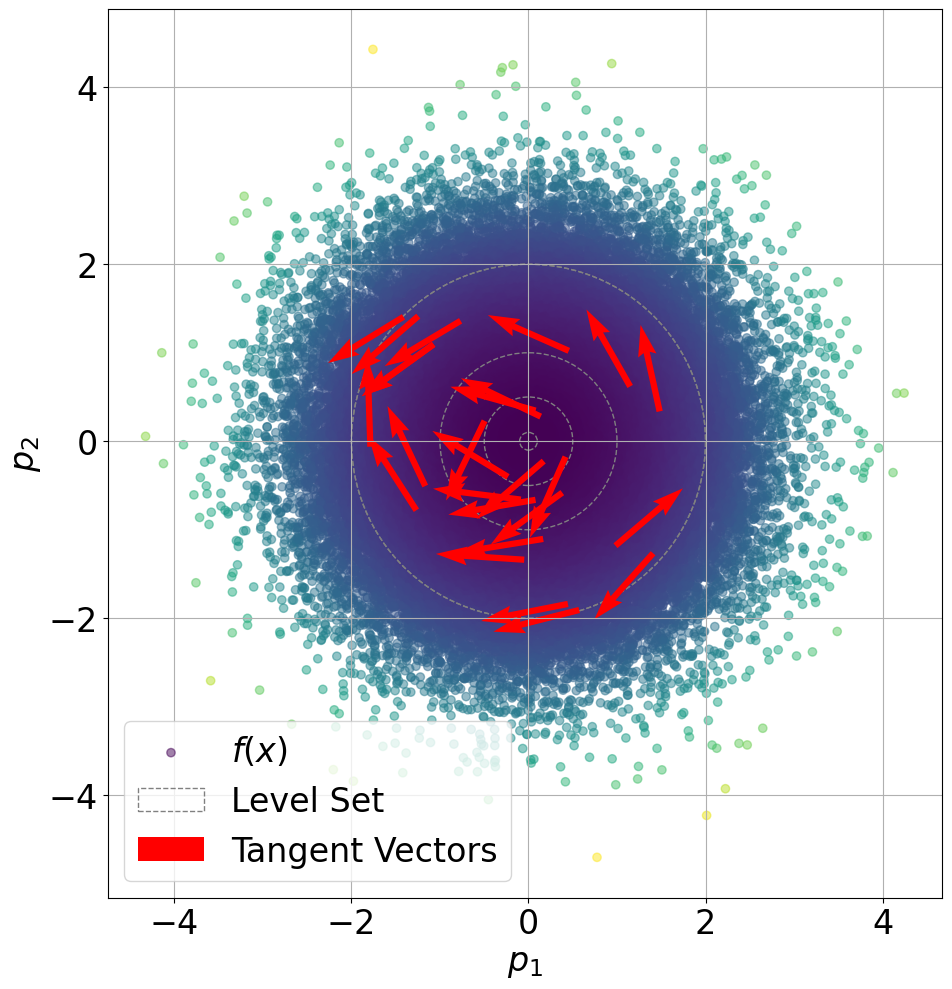

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

FILE_NAME = "tangent_plot.png"

def plot_tangent_vectors(s, y, basis, save_fig=False):
    """
    Plots sample points, level set circles, and tangent vectors.

    Parameters:
    - s: Tensor of shape (N, 2), point coordinates.
    - y: Tensor of shape (N,), function values (used for color).
    - basis: Dict[int, Tensor], tangent vectors at given indices.
    - save_fig: Bool, whether to save the figure.
    - save_path: Path to save the figure if save_fig is True.
    - fig_size: Tuple (width, height) in inches.
    - dpi: Resolution of saved figure.
    """
    random_indices = random.sample(list(basis.keys()), 25)

    fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

    # Scatter plot of the points
    ax.scatter(s.numpy()[:, 0], s.numpy()[:, 1], c=y.numpy(), label="$f(x)$", alpha=0.5)

    # Add level set circles centered at origin
    for radius in [0.1, 0.5, 1, 2]:
        circle = patches.Circle((0, 0), radius, fill=False, linestyle='--', linewidth=1, edgecolor='gray')
        ax.add_patch(circle)
    # Add a labeled circle for legend
    labeled_circle = patches.Circle((0, 0), radius, fill=False, linestyle='--', linewidth=1,
                                    edgecolor='gray', label="Level Set")
    ax.add_patch(labeled_circle)

    # Plot tangent vectors
    for idx in random_indices:
        point = s[idx].numpy()
        vector = basis[idx].numpy().flatten()
        ax.quiver(point[0], point[1], vector[0], vector[1],
                  angles='xy', scale_units='xy', scale=1, color='red')
    # Add one with label
    ax.quiver(point[0], point[1], vector[0], vector[1],
              angles='xy', scale_units='xy', scale=1, color='red', label="Tangent Vectors")

    ax.set_aspect('equal')
    ax.set_xlabel(r"$p_1$")
    ax.set_ylabel(r"$p_2$")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    if save_fig:
        fig.savefig(FILE_NAME, dpi=DPI, bbox_inches='tight')

    plt.show()

plot_tangent_vectors(s, y, basis, save_fig=False)



## Computing an Infinitesimal Generator

- In 1 dimension, tangent vector can only point in two directions
- We can find out whether tangent vectors at nearby points point in the same direction by computing their cosine similarity. If it is positive, they point in the same direction and if cosine similarity is negative, they point in opposite directions. Thereby, if the cosine similarity of nearby points is negative, we need to multiply the tangent vector by $-1$.

In [309]:
def orthogonal_projec(projection, p, subspace):
    """
    Projects a batched point p via a projection and computes its orthogonal component with respect to a given subspace.
    Args:
        generator: (d, n, n)
        p: (b, n)
        subspace: (b, n, d)
    Returns:
        p_ortho: (b, n)
    """

    # Project p into generator space: (b, d, n)
    p_proj = torch.einsum('dnm,bm->bdn', projection, p)

    # Reshape p_proj as (b, n) by summing across generator directions (if 1D kernel)
    # If d=1, this collapses to a single vector:
    if projection.shape[0] == 1:
        p_proj = p_proj[:, 0, :]  # shape (b, n)
    else:
        raise ValueError("Only 1D subspace supported in this projection version.")

    # Compute projection of p_gen into basis (b, n)
    subspace_pinv = torch.linalg.pinv(subspace)  # (b, d, n)
    coeffs = torch.einsum('bdn,bn->bd', subspace_pinv, p_proj)  # (b, d)
    p_subspace = torch.einsum('bnd,bd->bn', basis, coeffs)     # (b, n)

    # Orthogonal component
    p_ortho = p_proj - p_subspace

    return p_ortho

In [176]:
g_0 = torch.eye(n_features, dtype=DTYPE, requires_grad=True).unsqueeze(0)
g_0 = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE, requires_grad=True).unsqueeze(0)

BATCH_SIZE = 16


random_indices = random.sample(list(basis.keys()), BATCH_SIZE)
random_indices = [idx_point, neighbors[idx_point][3], neighbors[idx_point][4]] #for plotting

batch_points = s[random_indices]
batch_bases = torch.vstack([basis[i] for i in random_indices]).unsqueeze(-1)

oracle_bases = torch.eye(2).unsqueeze(0).repeat(BATCH_SIZE, 1, 1)


ortho_comp = orthogonal_projec(g_0, batch_points, batch_bases)

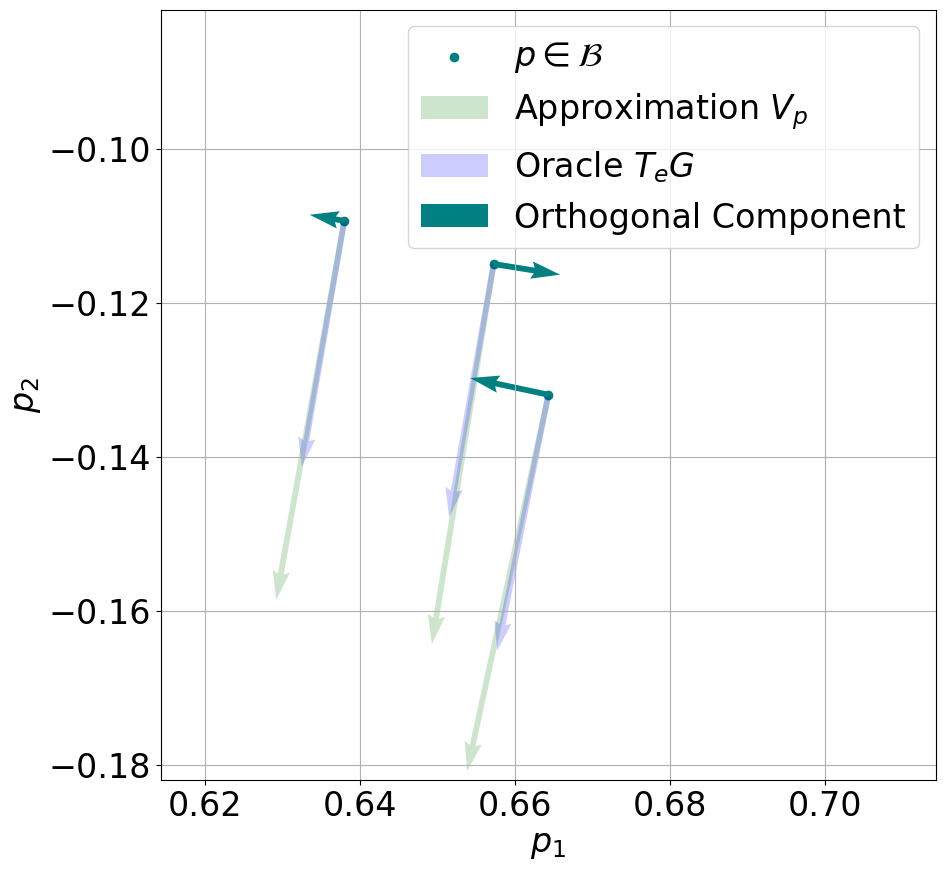

In [190]:
ground_truth_kernel = torch.einsum('dnm, bm->bdn', g_0, batch_points).squeeze(1)
ground_truth_kernel = ground_truth_kernel*-1
import matplotlib.pyplot as plt

QUIVER_SCALE = 20
ORTHO_SCALE = 20
PADDING = 0.05

ortho_comp_scaled = ortho_comp * ORTHO_SCALE

# Plot the ground truth kernel vectors anchored at batch_points
plt.figure(figsize=(FIG_HEIGHT, FIG_HEIGHT))
plt.scatter(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1], color=(0.0, 0.5, 0.5), label="$p \in \mathcal{B}$")

plt.quiver(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1],
                   batch_bases.numpy()[:, 0, 0], batch_bases.numpy()[:, 1, 0],
                   angles='xy', scale_units='xy', scale=QUIVER_SCALE, color='green', label="Approximation $V_p$", alpha=0.2)
plt.quiver(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1],
           ground_truth_kernel.detach().numpy()[:, 0], ground_truth_kernel.detach().numpy()[:, 1],
           angles='xy', scale_units='xy', scale=QUIVER_SCALE, color='blue', label="Oracle $T_eG$", alpha=0.2)
        # Plot the batch_basis vectors anchored at batch_points

plt.quiver(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1],
                   ortho_comp_scaled.detach().numpy()[:, 0], ortho_comp_scaled.detach().numpy()[:, 1],
                   angles='xy', scale_units='xy', scale=QUIVER_SCALE, color=(0.0, 0.5, 0.5), label="Orthogonal Component")
# Scatter plot for batch points

plt.xlabel(r"$p_1$")
plt.ylabel(r"$p_2$")
plt.xlim(s[idx_point][0]-PADDING, s[idx_point][0]+PADDING)
plt.ylim(s[idx_point][1]-PADDING, s[idx_point][1]+PADDING)
plt.legend()
plt.grid(True)
plt.show()

## Learning the Generator

In [117]:
g_0 = torch.eye(n_features, dtype=DTYPE, requires_grad=True).unsqueeze(0)

BATCH_SIZE = 16

class DiffGenerator():
    """Learns a differential generator given pointwise evaluations of the Kernel."""

    def __init__(self,
                 g_0, 
                 p, 
                 bases,
                 batch_size: int,
                 n_steps: int,
                 learn_symmetry: bool,
                 learn_maximal: bool):
        """
        Learns a maximal symmetry from point-wise bases.

        Args:
        - g_0: torch.tensor, initialization of the infinitesimal generator
        - p: torch.tensor, samples
        - bases: torch.tensor, point-wise bases
        - batch_size: int
        - n_steps: int, number of gradient steps
        - learn_symmetry: bool, whether to compute orthogonal complement of infinitesimal generator w.r.t. bases (default should be true)
        - learn_maximal: bool, whether to compute orthogonal complement of bases w.r.t. infinitesimal generator (default can be true or false, 
                         false may learn subsymmetry but more stable while true learns maximal symmetry but less stable)
        """
        
        self.g = g_0
        self.p = p
        self.bases = bases

        self._optimizer_func = torch.optim.Adam([g_0], lr=0.00045)

        self._batch_size = batch_size
        self._n_steps = n_steps
        self._learn_symmetry = learn_symmetry
        self._learn_maximal = learn_maximal

        self._bases_idxs = list(self.bases.keys())
        self._losses = []
        self._losses_symmetry = []
        self._losses_maximal = []

    def orthogonal_projec(self,
                          infinitesimal_generator, 
                          ps, 
                          kernel_bases):
        """
        Projects a batched point p via a projection and computes its orthogonal component with respect to a given subspace.
        Args:
            infinitesimal_generator: (d, n, n)
            p: (b, n)
            kernel_bases: (b, n, d)
        Returns:
            p_ortho: (b, n)

        where:
        - b: batch size
        - d, f: generator dimension, d=f
        - n, m: manifold ambient dimensions, n=m
        """
        #TODO, fix this, kernel bases should have correct shape from the beginning.
        kernel_bases = kernel_bases.transpose(1,2) #(b,d,n)


        def project_onto_subspace(vecs, basis):
            """Projects a set of vectors into a vector space spanned by basis.
            vecs: tensor of shape (b,d,n)
            basis: tensor of shape (b,d,n)
            """
            basis_t = basis.transpose(1, 2)  #(b,n,d)
            
            # Compute Gram matrix and its pseudo-inverse: (b,d,d)
            G = torch.matmul(basis, basis_t)  # (b,d,d)
            G_inv = torch.linalg.pinv(G)

            # Compute projection matrix: (b,n,n)
            P = torch.matmul(basis_t, torch.matmul(G_inv, basis))  # (b,n,n)
            
            # Project vecs: (b,d,n)
            return torch.matmul(vecs, P)  # (b,d,n)
        

        # Batch Infinitesimal Generator
        infinitesimal_generator_batched_ = infinitesimal_generator.unsqueeze(0)
        infinitesimal_generator_batched = infinitesimal_generator_batched_.repeat(self._batch_size, 1, 1, 1)
        del infinitesimal_generator_batched_, infinitesimal_generator

        # Step 1: Use infinitesimal generator to compute differential generator bases at points p according to infinitesimal generator.
        gen_bases = torch.einsum('bdnm,bm->bdn', infinitesimal_generator_batched, ps)

        # Step 2a: Symmetry: Check whether each basis vector in kernel_bases_diff_gen is in the span of kernel_bases.
        # To this end, compute orthogonal complement:
        proj_gen_on_kernel = project_onto_subspace(gen_bases, kernel_bases)
        orth_gen_on_kernel = gen_bases - proj_gen_on_kernel


        # Step 2b: Maximal: Check whether each kernel basis vector is in the span of gen_bases.
        proj_kernel_on_gen = project_onto_subspace(kernel_bases, gen_bases)
        orth_kernel_on_gen = kernel_bases - proj_kernel_on_gen


        return orth_gen_on_kernel, orth_kernel_on_gen
    

    def take_one_gradient_step(self,
                      p_batch,
                      bases_batch):
        
        # Normalize infinitesimal generator to have unit Frobenius norm in each Lie group dimension.
        self.g_norm = self._normalize_tensor(tensor=self.g, dim=(1,2))
        
        # Compute orthogonal complement of differential generator with respect to kernel bases and orth.complement of kernel bases with respect to diff. generator.
        orth_gen_on_kernel, orth_kernel_on_gen = self.orthogonal_projec(infinitesimal_generator=self.g_norm,
                                                                        ps = p_batch,
                                                                        kernel_bases = bases_batch)
        
        # Minimize orthogonal complements. Here, orth_gen_on_kernel and orth_kernel_on_gen are of shape (b,d,n) and we compute the norm along d and n
        # which is zero if each basis vector is contained in the span of the respective other vectors.
        loss_symmetry = torch.sum(torch.norm(orth_gen_on_kernel, dim=(1,2)), dim=0)
        loss_maximal = torch.sum(torch.norm(orth_kernel_on_gen, dim=(1,2)), dim=0)

        # Final loss
        loss = loss_symmetry + loss_maximal

        # Update generator
        self._optimizer_func.zero_grad()
        loss.backward()
        self._optimizer_func.step()

        self._losses_symmetry.append(loss_symmetry.detach().numpy())
        self._losses_maximal.append(loss_maximal.detach().numpy())
        self._losses.append(loss.detach().numpy())

    
    def _normalize_tensor(self, tensor, dim, norm='fro'):
        """Normalizes a tensor along given dimensions to have unit Frobenius norm."""
        _norm_tensor = tensor.norm(p=norm, dim=dim, keepdim=True) + 1e-8 #(d,d,n)
        return tensor/_norm_tensor
    
    def optimize(self):
        """Main Optimization Loop."""
        for _ in range(self._n_steps):

            idxs = random.sample(self._bases_idxs, self._batch_size)
            p_batch = self.p[idxs]
            bases_batch = torch.vstack([self.bases[i] for i in idxs]).unsqueeze(-1) #(b, n, d)

            # Normalize bases to have unit Frobenius norm
            bases_batch = self._normalize_tensor(tensor=bases_batch, dim=(1,2))

            self.take_one_gradient_step(p_batch, bases_batch)

        return self.g_norm
    
g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
g_0 = torch.nn.Parameter(g_init_all)

diff_generator = DiffGenerator(
    g_0=g_0,
    p=s,
    bases=basis,
    batch_size=128,
    n_steps = 20_000,
    learn_symmetry=True,
    learn_maximal=True,
)
diff_generator.optimize()

tensor([[[-9.4893e-04, -7.0713e-01],
         [ 7.0709e-01,  3.2369e-04]]], grad_fn=<DivBackward0>)

## Train

In [15]:
g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
g_0 = torch.nn.Parameter(g_init_all)

diff_generator = DiffGenerator(
    g_0=g_0,
    p=s,
    bases=basis,
    batch_size=128,
    n_steps = 25_000,
    learn_symmetry=True,
    learn_maximal=False,
)

# Learned Kernel

In [118]:
N_VEC_PLOT = 64
N_MESH = 10
QUIVER_SCALE_v2 = 1

def plot_learned_generator(generator, 
                           ax,
                           quiver_scale: float,
                           title: str = None):
    """Plots the vector field generated by a 2D generator into the provided axis.

    Args:
    - generator: torch.tensor of shape (kernel_dim, feature_dim, feature_dim) where feature_dim=2
    - ax: matplotlib.axes.Axes object to draw the quiver plot into
    - quiver_scale: float, scale of the quivers, larger values make quivers smallers
    - title: Optional title for the plot
    """
    # Create a mesh grid over the 2D plane
    x_min, x_max = s[:, 0].min().item() - 0.5, s[:, 0].max().item() + 0.5
    y_min, y_max = s[:, 1].min().item() - 0.5, s[:, 1].max().item() + 0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, N_MESH),
                            torch.linspace(y_min, y_max, N_MESH),
                            indexing='ij')
    mesh_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

    # Compute the kernel for the mesh points
    mesh_kernel = torch.einsum('dnm, bm->bdn', generator, mesh_points).squeeze(1)

    # Reshape for plotting
    mesh_kernel_x = mesh_kernel[:, 0].reshape(xx.shape)
    mesh_kernel_y = mesh_kernel[:, 1].reshape(yy.shape)

    # Plot the vector field
    ax.quiver(xx.numpy(), yy.numpy(),
              mesh_kernel_x.detach().numpy(),
              mesh_kernel_y.detach().numpy(),
              angles='xy', scale_units='xy', scale=quiver_scale,
              color="blue")

    ax.set_aspect('equal')
    ax.grid(True)
    if title:
        ax.set_title(title)


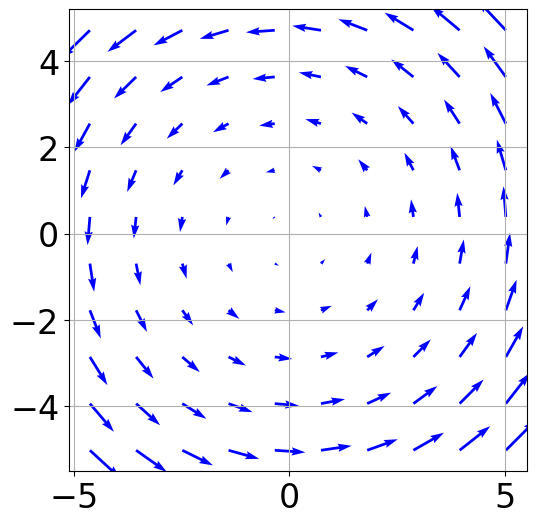

In [122]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

plot_learned_generator(diff_generator.g_norm, axes, quiver_scale=5)

In [123]:
diff_generators = []
# g_0 = torch.eye(n_features, dtype=DTYPE).unsqueeze(0) # shape (k, D, D)

for _ in range(10):
    # g_init_all = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE).unsqueeze(0)
    g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
    # g_init = g_init_all.clone()
    g_0 = torch.nn.Parameter(g_init_all)

    diff_generator = DiffGenerator(
        g_0=g_0,
        p=s,
        bases=basis,
        batch_size=128,
        n_steps = 5_000,
        learn_maximal=True,
        learn_symmetry=True
    )

    # Optimize
    g_plus = diff_generator.optimize()
    diff_generators.append(diff_generator)
    del g_0, g_plus

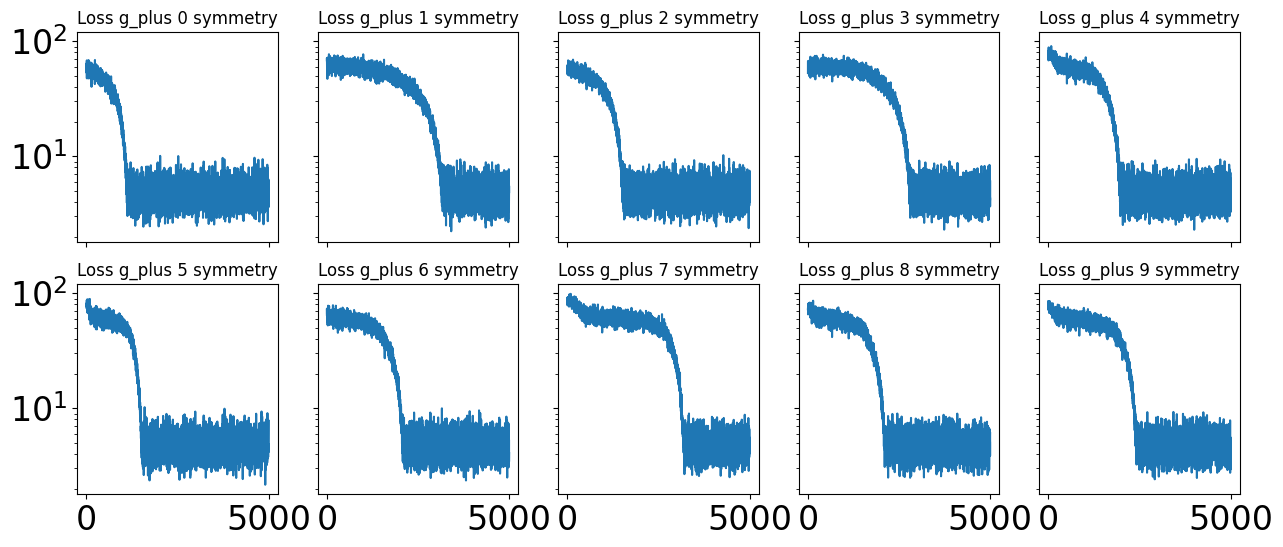

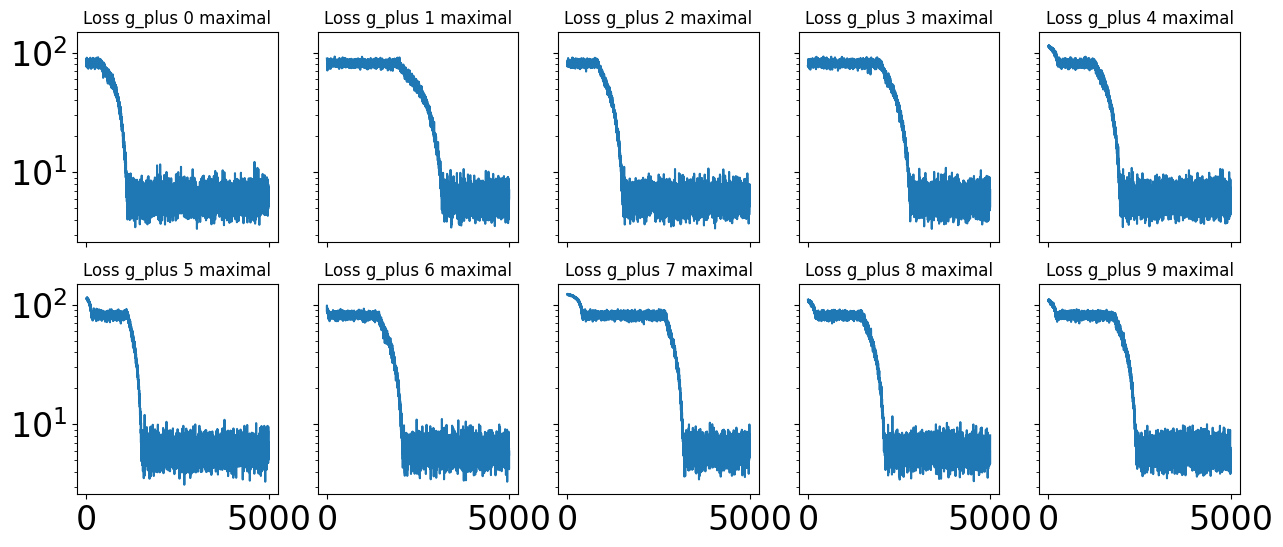

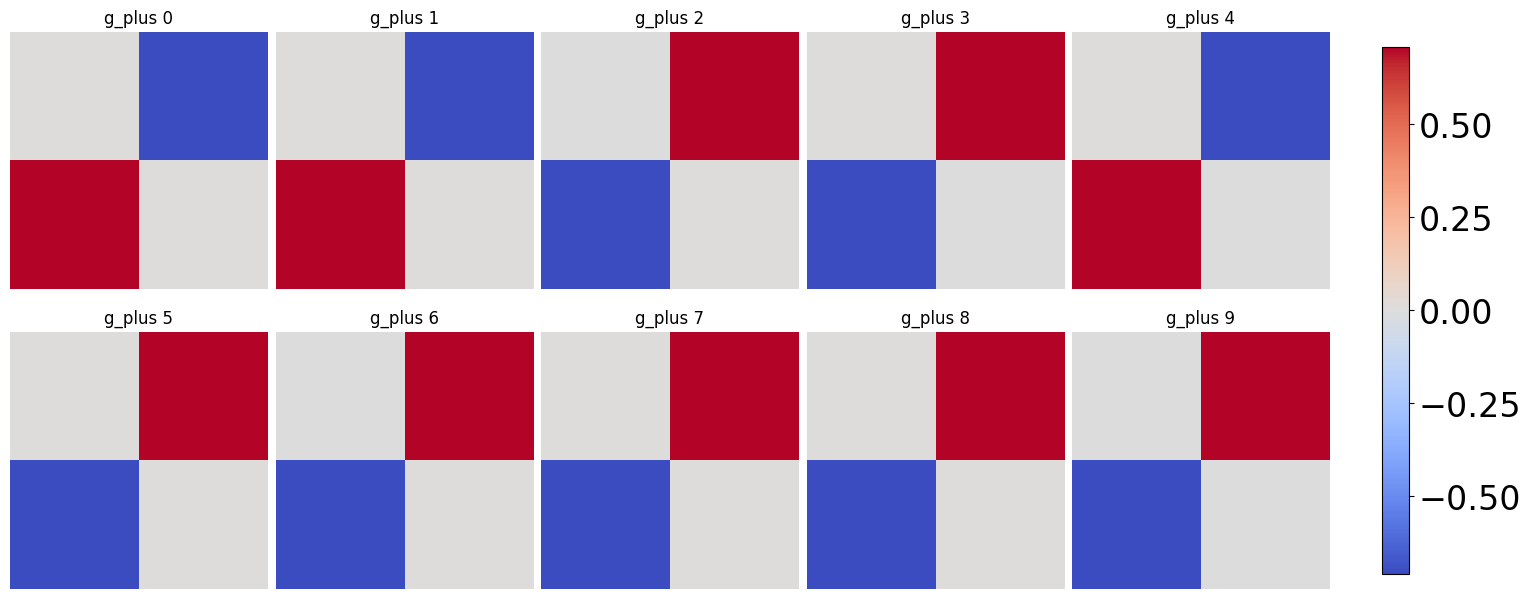

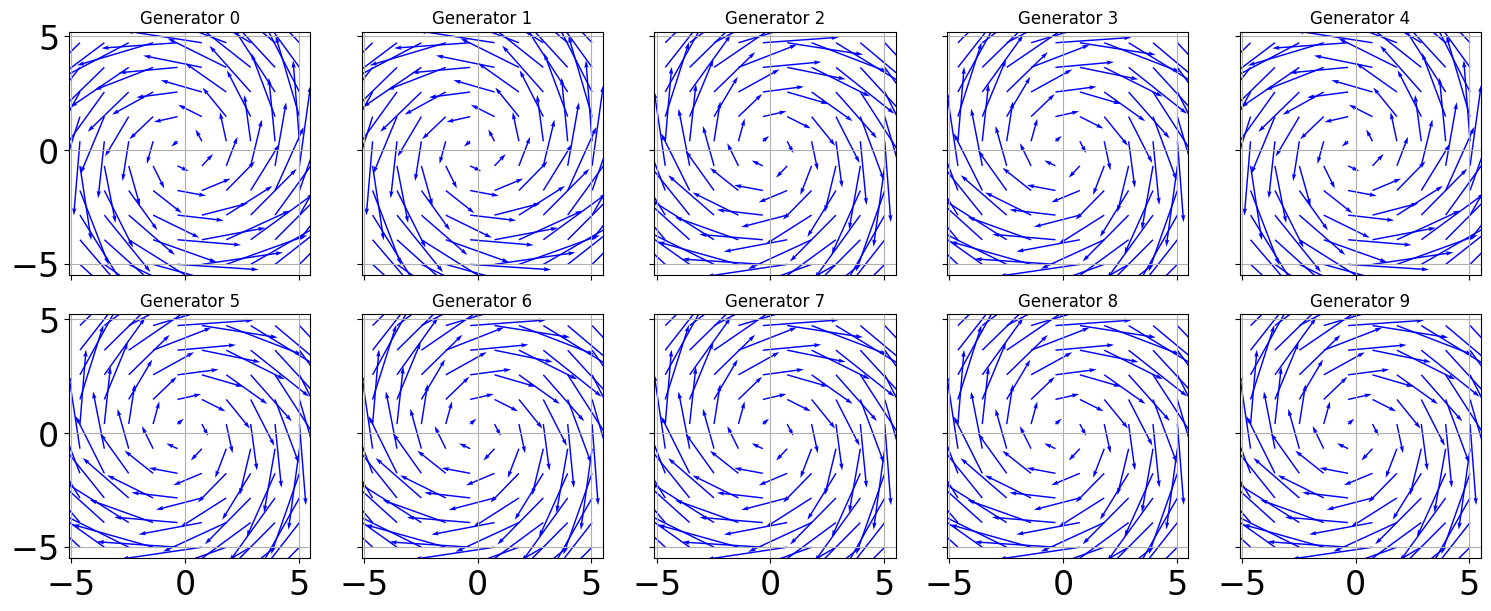

In [124]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    ax.plot(diff_generators[i]._losses_symmetry)
    ax.set_title(f"Loss g_plus {i} symmetry")
    ax.set_yscale("log")

fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    ax.plot(diff_generators[i]._losses_maximal)
    ax.set_title(f"Loss g_plus {i} maximal")
    ax.set_yscale("log")

fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
vmin = min(diff_generator.g_norm[0, :, :].detach().numpy().min() for diff_generator in diff_generators)
vmax = max(diff_generator.g_norm[0, :, :].detach().numpy().max() for diff_generator in diff_generators)

for i, ax in enumerate(axes.flat):
        im = ax.imshow(diff_generators[i].g_norm[0, :, :].detach().numpy(), vmin=vmin, vmax=vmax, cmap="coolwarm")
        ax.set_title(f"g_plus {i}")
        ax.axis('off')

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)


fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    plot_learned_generator(diff_generators[i].g_norm, ax, title=f"Generator {i}", quiver_scale=1)


## Functional Symmetry Discovery

In [98]:
g_0 = torch.eye(n_features, dtype=DTYPE, requires_grad=True).unsqueeze(0)

BATCH_SIZE = 16

class FuncGenerator():
    """Learns a differential generator via functional symmetry discovery."""

    def __init__(self,
                 g_0, 
                 p,
                 func: callable,
                 batch_size: int,
                 n_steps: int):
        """
        Learns a maximal symmetry from point-wise bases.

        Args:
        - g_0: torch.tensor, initialization of the infinitesimal generator
        - p: torch.tensor, samples
        - func: callable, the function for which we aim to learn a symmetry.
        - batch_size: int
        - n_steps: int, number of gradient steps
                         false may learn subsymmetry but more stable while true learns maximal symmetry but less stable)
        """
        
        self.g = g_0
        self.p = p
        self.func = func

        self._optimizer_func = torch.optim.Adam([g_0], lr=0.00045)

        self._batch_size = batch_size
        self._n_steps = n_steps
        self._group_dim = self.g.shape[0]

        self._losses = []


    def take_one_gradient_step(self,
                      p_batch,
                      group_actions_batch
                      ):
        
        # Normalize infinitesimal generator to have unit Frobenius norm in each Lie group dimension.
        self.g_norm = self._normalize_tensor(tensor=self.g, dim=(1,2))
        self.g_norm_batched_ = self.g_norm.unsqueeze(0)
        self.g_norm_batched = self.g_norm_batched_.repeat(self._batch_size, 1, 1, 1) #(b, d, m, n)

        #
        group_actions_batch = group_actions_batch.view(self._batch_size, 1, 1, 1) #(b, 1, 1, 1)
    
        # Compute group actions via matrix exponential
        diff_group_action = torch.sum(group_actions_batch*self.g_norm_batched, dim=1) #(b,m,n) #TODO, is this correct
        group_actions_batched = torch.matrix_exp(diff_group_action)

        # Compute loss
        image_f_raw = self.func(p_batch)
        image_f_group = self.func(torch.einsum('bnm,bm->bn', group_actions_batched, p_batch))
        loss =  torch.norm(image_f_raw - image_f_group, dim=-1).sum(dim=0)

        # Update generator
        self._optimizer_func.zero_grad()
        loss.backward()
        self._optimizer_func.step()

        self._losses.append(loss.detach().numpy())

    
    def _normalize_tensor(self, tensor, dim, norm='fro'):
        """Normalizes a tensor along given dimensions to have unit Frobenius norm."""
        _norm_tensor = tensor.norm(p=norm, dim=dim, keepdim=True) + 1e-8 #(d,d,n)
        return tensor/_norm_tensor
    

    def optimize(self):
        """Main Optimization Loop."""
        for _ in range(self._n_steps):

            idxs = random.sample(list(range(len(s))), self._batch_size)
            p_batch = self.p[idxs]

            # Group actions
            # TODO, currently for symmetry group, change to arbitrary coefficients
            coeffs_group_batch = torch.rand((self._batch_size, self._group_dim))*2*torch.pi

            self.take_one_gradient_step(p_batch, coeffs_group_batch)

        return self.g_norm
    
def f(state, cost_matrix=cost_matrix):
    """Evaluates f for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

# g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
# g_init_all = torch.tensor([[0.0, -1.0], [1.0,0.0]]).unsqueeze(0)
# g_0 = torch.nn.Parameter(g_init_all)

# func_generator = FuncGenerator(
#     g_0=g_0,
#     p=s,
#     func=f,
#     batch_size=128,
#     n_steps = 5_000,
# )

# out = func_generator.optimize()

In [102]:
def f(state, cost_matrix=cost_matrix):
    """Evaluates f for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
g_0 = torch.nn.Parameter(g_init_all)

func_generator = FuncGenerator(
    g_0=g_0,
    p=s,
    func=f,
    batch_size=128,
    n_steps = 25_000,
)

func_generator.optimize()

KeyboardInterrupt: 

In [109]:
func_generators = []
# g_0 = torch.eye(n_features, dtype=DTYPE).unsqueeze(0) # shape (k, D, D)

for _ in range(10):
    # g_init_all = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE).unsqueeze(0)
    g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
    g_0 = torch.nn.Parameter(g_init_all)

    func_generator = FuncGenerator(
        g_0=g_0,
        p=s,
        func=f,
        batch_size=128,
        n_steps = 25_000,
    )

    # Optimize
    g_plus = func_generator.optimize()
    func_generators.append(func_generator)
    del g_0, g_plus

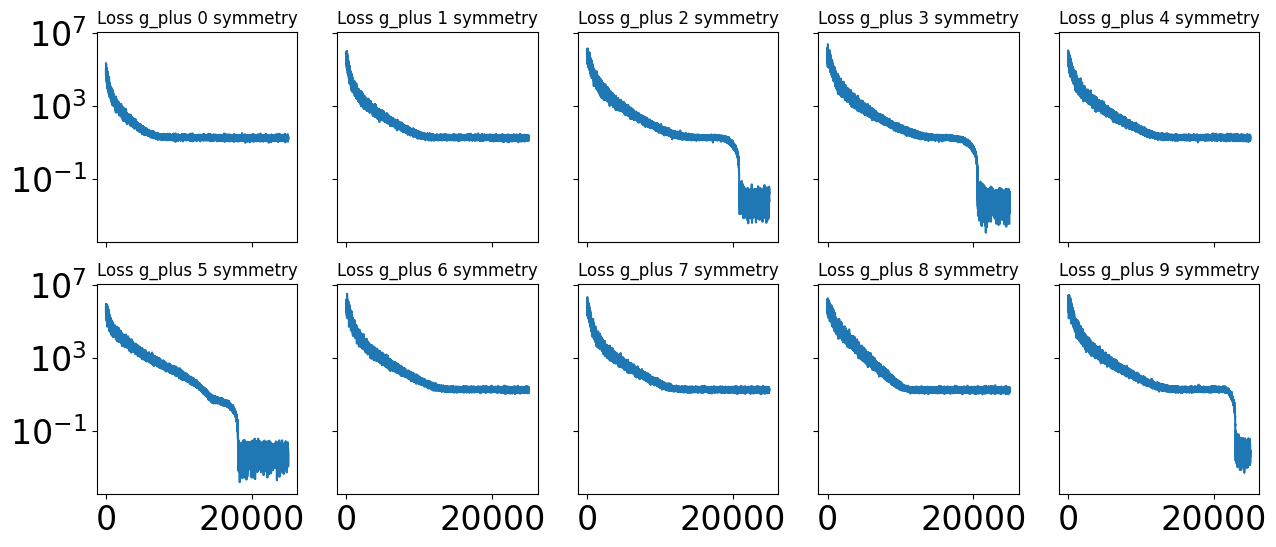

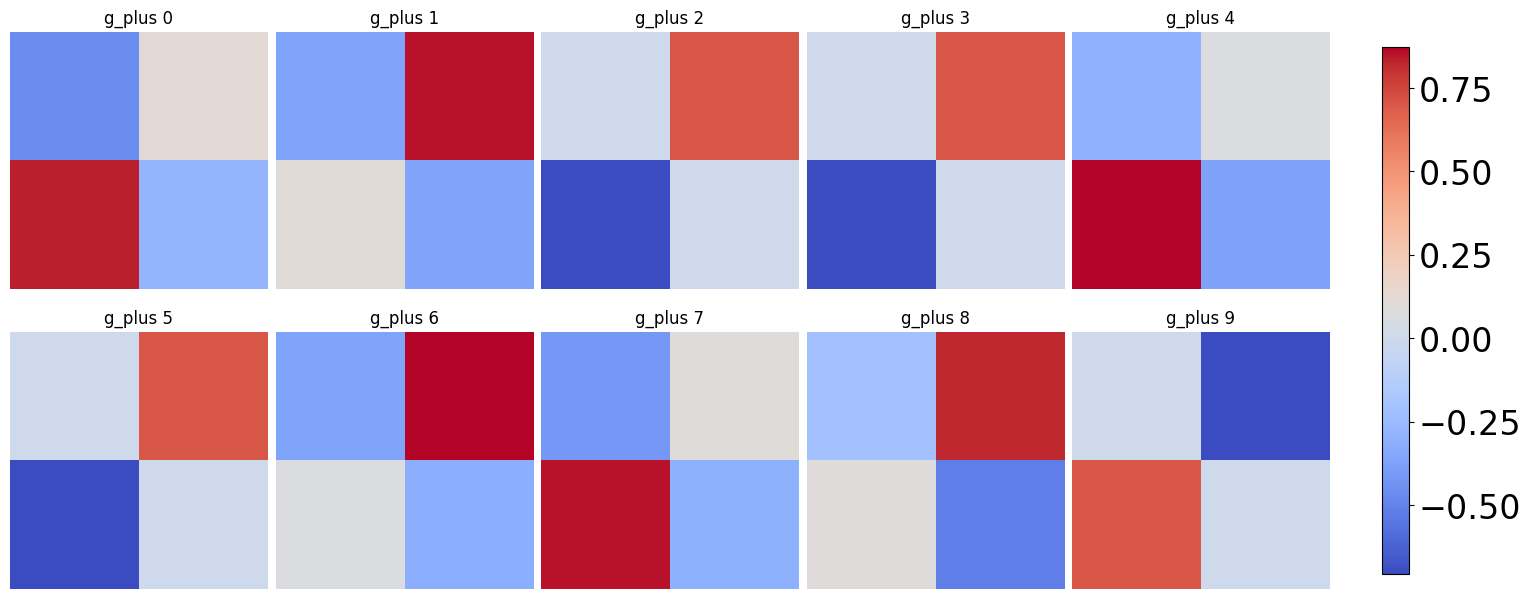

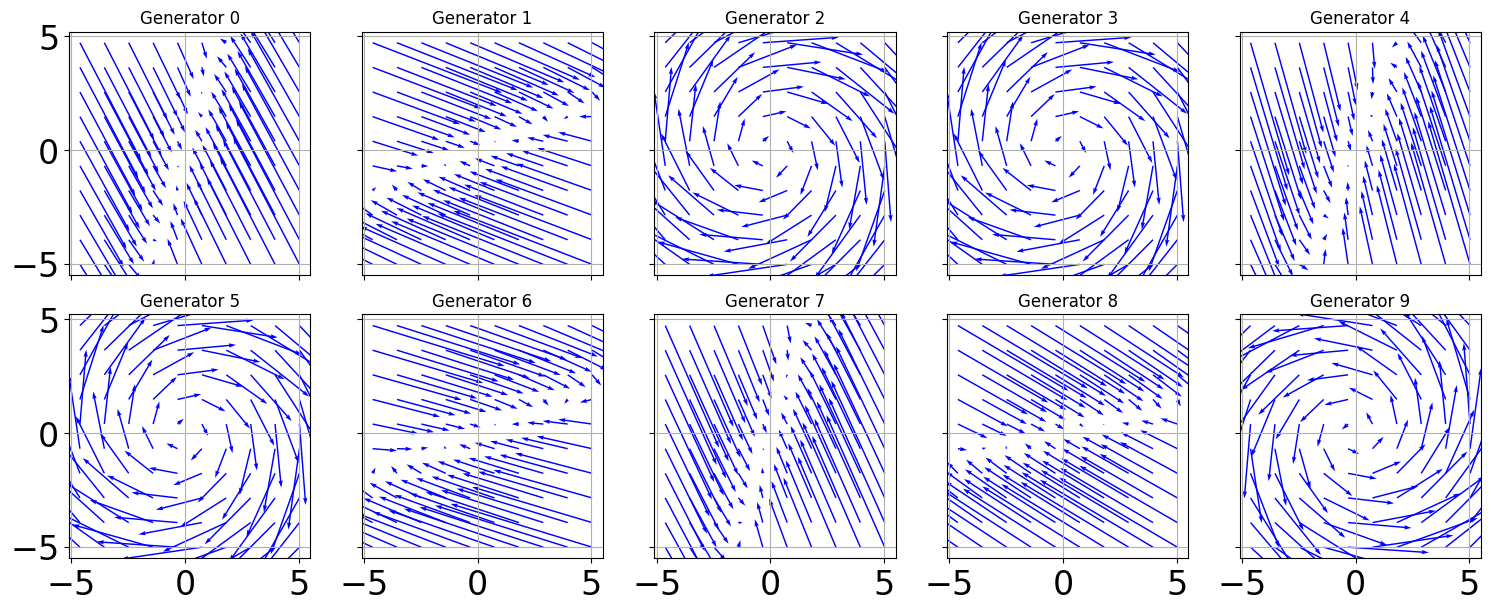

In [110]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    ax.plot(func_generators[i]._losses)
    ax.set_title(f"Loss g_plus {i} symmetry")
    ax.set_yscale("log")


fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
vmin = min(func_generator.g_norm[0, :, :].detach().numpy().min() for func_generator in func_generators)
vmax = max(func_generator.g_norm[0, :, :].detach().numpy().max() for func_generator in func_generators)

for i, ax in enumerate(axes.flat):
        im = ax.imshow(func_generators[i].g_norm[0, :, :].detach().numpy(), vmin=vmin, vmax=vmax, cmap="coolwarm")
        ax.set_title(f"g_plus {i}")
        ax.axis('off')

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)


fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True, sharex= True, sharey=True)
for i, ax in enumerate(axes.flat):
    plot_learned_generator(func_generators[i].g_norm, ax, title=f"Generator {i}", quiver_scale=1)


## Comparing Both Approaches

In [ ]:
g_0 = torch.eye(n_features, dtype=DTYPE, requires_grad=True).unsqueeze(0)

BATCH_SIZE = 16

class FuncDiffGenerator():
    """Learns a differential generator via both functional and symmetry discovery."""

    def __init__(self,
                 g_0, 
                 p,
                 func: callable,
                 bases,
                 batch_size: int,
                 n_steps: int):
        """
        Learns a maximal symmetry from point-wise bases.

        Args:
        - g_0: torch.tensor, initialization of the infinitesimal generator
        - p: torch.tensor, samples
        - func: callable, the function for which we aim to learn a symmetry.
        - batch_size: int
        - n_steps: int, number of gradient steps
                         false may learn subsymmetry but more stable while true learns maximal symmetry but less stable)
        """
        
        self.g_func = torch.nn.Parameter(g_0.clone().detach().requires_grad_(True))
        self.g_diff = torch.nn.Parameter(g_0.clone().detach().requires_grad_(True))
        self.p = p
        self.func = func
        self.bases = bases

        self._optimizer_func = torch.optim.Adam([self.g_func], lr=0.00045)
        self._optimizer_diff = torch.optim.Adam([self.g_diff], lr=0.00045)

        self._batch_size = batch_size
        self._n_steps = n_steps
        self._group_dim = self.g.shape[0]

        self._losses_func = []
        self._losses_diff = []
        self._bases_idxs = list(self.bases.keys())


    def orthogonal_projec_generator_into_kernel(self,
                          generator, 
                          p, 
                          subspace):
        """
        Projects a batched point p via a projection and computes its orthogonal component with respect to a given subspace.
        Args:
            generator: (d, n, n)
            p: (b, n)
            subspace: (b, n, d)
        Returns:
            p_ortho: (b, n)

        where:
        - b: batch size
        - d, f: generator dimension, d=f
        - n, m: manifold ambient dimensions, n=m
        """

        # Project p via projection
        p_proj = torch.einsum('dnm,bm->bdn', generator, p)

        # TODO: collaps to 1 dimension, is this correct?
        p_proj = torch.einsum('bdn->bn', p_proj)

        # Compute projection of p_gen into basis (b, n)
        subspace_pinv = torch.linalg.pinv(subspace)  # (b, d, n)
        coeffs = torch.einsum('bdn,bn->bd', subspace_pinv, p_proj)
        p_subspace = torch.einsum('bnd,bd->bn', subspace, coeffs)

        # Orthogonal component
        p_ortho = p_proj - p_subspace

        return p_ortho
    

    def orthogonal_projec_kernel_into_generator(self,
                          kernel, 
                          p, 
                          subspace):
        """
        Projects a batched point p via a projection and computes its orthogonal component with respect to a given subspace.
        Args:
            kernel: (d, n, n)
            p: (b, n)
            subspace: (b, n, d)
        Returns:
            p_ortho: (b, n)

        where:
        - b: batch size
        - d, f: generator dimension, d=f
        - n, m: manifold ambient dimensions, n=m
        """
        kernel_batched = kernel.unsqueeze(0)
        kernel_batched = kernel_batched.repeat(self._batch_size, 1, 1, 1)

        # Project p via projection
        p_proj = torch.einsum('bdnm,bm->bdn', kernel_batched, p)

        # Compute projection of p_gen into basis (b, n)
        kernel_pinv = torch.linalg.pinv(kernel_batched)  # (b, d, n, m)

        coeffs = torch.einsum('bdnm,bdm->bdn', kernel_pinv, p_proj)
        p_kernel = torch.einsum('bdnm,bdm->bn', kernel_batched, coeffs)

        #TODO, this dimension trick only works in one dimension. think about how to fix it in higher dimensions. This adds
        # the Lie algebra dimension to p_kernel (where did we lose it)? In the correct code, we need to do the projection along
        # each lie algebra dimension and then sum all of these orthogonal complements up.
        p_proj = p_proj.squeeze(1)

        # Orthogonal component
        p_ortho = p_proj - p_kernel

        return p_ortho


    def take_one_gradient_step_func(self,
                      p_batch,
                      group_actions_batch
                      ):
        
        # Normalize infinitesimal generator to have unit Frobenius norm in each Lie group dimension.
        self.g_norm = self._normalize_tensor(tensor=self.g, dim=(1,2))
        self.g_norm_batched_ = self.g_norm.unsqueeze(0)
        self.g_norm_batched = self.g_norm_batched_.repeat(self._batch_size, 1, 1, 1) #(b, d, m, n)

        #
        group_actions_batch = group_actions_batch.view(self._batch_size, 1, 1, 1) #(b, 1, 1, 1)
    
        # Compute group actions via matrix exponential
        diff_group_action = torch.sum(group_actions_batch*self.g_norm_batched, dim=1) #(b,m,n) #TODO, is this correct
        group_actions_batched = torch.matrix_exp(diff_group_action)

        # Compute loss
        image_f_raw = self.func(p_batch)
        image_f_group = self.func(torch.einsum('bnm,bm->bn', group_actions_batched, p_batch))
        loss =  torch.norm(image_f_raw - image_f_group, dim=-1).sum(dim=0)

        # Update generator
        self._optimizer_func.zero_grad()
        loss.backward()
        self._optimizer_func.step()

        self._losses.append(loss.detach().numpy())

    
    def _normalize_tensor(self, tensor, dim, norm='fro'):
        """Normalizes a tensor along given dimensions to have unit Frobenius norm."""
        _norm_tensor = tensor.norm(p=norm, dim=dim, keepdim=True) + 1e-8 #(d,d,n)
        return tensor/_norm_tensor
    

    def optimize(self):
        """Main Optimization Loop."""
        for _ in range(self._n_steps):

            idxs = random.sample(list(range(len(s))), self._batch_size)
            p_batch = self.p[idxs]

            # Group actions
            # TODO, currently for symmetry group, change to arbitrary coefficients
            coeffs_group_batch = torch.rand((self._batch_size, self._group_dim))*2*torch.pi

            self.take_one_gradient_step(p_batch, coeffs_group_batch)

        return self.g_norm
    
def f(state, cost_matrix=cost_matrix):
    """Evaluates f for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

# g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
# g_init_all = torch.tensor([[0.0, -1.0], [1.0,0.0]]).unsqueeze(0)
# g_0 = torch.nn.Parameter(g_init_all)

# func_generator = FuncGenerator(
#     g_0=g_0,
#     p=s,
#     func=f,
#     batch_size=128,
#     n_steps = 5_000,
# )

# out = func_generator.optimize()

g_0 = torch.eye(n_features, dtype=DTYPE, requires_grad=True).unsqueeze(0)

BATCH_SIZE = 16

class DiffGenerator():
    """Learns a differential generator given pointwise evaluations of the Kernel."""

    def __init__(self,
                 g_0, 
                 p, 
                 bases,
                 batch_size: int,
                 n_steps: int,
                 learn_symmetry: bool,
                 learn_maximal: bool):
        """
        Learns a maximal symmetry from point-wise bases.

        Args:
        - g_0: torch.tensor, initialization of the infinitesimal generator
        - p: torch.tensor, samples
        - bases: torch.tensor, point-wise bases
        - batch_size: int
        - n_steps: int, number of gradient steps
        - learn_symmetry: bool, whether to compute orthogonal complement of infinitesimal generator w.r.t. bases (default should be true)
        - learn_maximal: bool, whether to compute orthogonal complement of bases w.r.t. infinitesimal generator (default can be true or false, 
                         false may learn subsymmetry but more stable while true learns maximal symmetry but less stable)
        """
        
        self.g = g_0
        self.p = p
        self.bases = bases

        self._optimizer_func = torch.optim.Adam([g_0], lr=0.00045)

        self._batch_size = batch_size
        self._n_steps = n_steps
        self._learn_symmetry = learn_symmetry
        self._learn_maximal = learn_maximal

        self._bases_idxs = list(self.bases.keys())
        self._losses = []
        self._losses_symmetry = []
        self._losses_maximal = []


    def take_one_gradient_step(self,
                      p_batch,
                      bases_batch):
        
        # Normalize infinitesimal generator to have unit Frobenius norm in each Lie group dimension.
        self.g_norm = self._normalize_tensor(tensor=self.g, dim=(1,2))
        
        # Project p_batch into self.g and compute orthogonal component with respect to bases. This ensures that the generator is a subspace of the kernel.
        if self._learn_symmetry:
            ortho_comp_bases = self.orthogonal_projec_generator_into_kernel(self.g_norm, p_batch, bases_batch)
            loss_symmetry = torch.sum(torch.norm(ortho_comp_bases, dim=1), dim=0)
        else:
            loss_symmetry = torch.tensor([0.0], requires_grad=True)

        # Project p_batch into bases_batch and compute orthogonal component with respect to self.g. This ensures that the kernel is a subspace of the generator.
        if self._learn_maximal:
            ortho_comp_g = self.orthogonal_projec_kernel_into_generator(self.g_norm, p_batch, bases_batch)
            loss_maximal = torch.sum(torch.norm(ortho_comp_g, dim=1), dim=0)
        else:
            loss_maximal = torch.tensor([0.0], requires_grad=True)

        # Compute loss
        loss = loss_symmetry + loss_maximal

        # Update generator
        self._optimizer_func.zero_grad()
        loss.backward()
        self._optimizer_func.step()

        self._losses_symmetry.append(loss_symmetry.detach().numpy())
        self._losses_maximal.append(loss_maximal.detach().numpy())
        self._losses.append(loss.detach().numpy())

    
    def _normalize_tensor(self, tensor, dim, norm='fro'):
        """Normalizes a tensor along given dimensions to have unit Frobenius norm."""
        _norm_tensor = tensor.norm(p=norm, dim=dim, keepdim=True) + 1e-8 #(d,d,n)
        return tensor/_norm_tensor
    
    def optimize(self):
        """Main Optimization Loop."""
        for _ in range(self._n_steps):

            idxs = random.sample(self._bases_idxs, self._batch_size)
            p_batch = self.p[idxs]
            bases_batch = torch.vstack([self.bases[i] for i in idxs]).unsqueeze(-1) #(b, n, d)

            # Normalize bases to have unit Frobenius norm
            bases_batch = self._normalize_tensor(tensor=bases_batch, dim=(1,2))

            self.take_one_gradient_step(p_batch, bases_batch)

        return self.g_norm
    
# g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
# g_0 = torch.nn.Parameter(g_init_all)

# diff_generator = DiffGenerator(
#     g_0=g_0,
#     p=s,
#     bases=basis,
#     batch_size=128,
#     n_steps = 20_000,
#     learn_symmetry=True,
#     learn_maximal=True,
# )
# diff_generator.optimize()

In [111]:
func_generators = []
diff_generators = []
N_RUNS = 10
N_STEPS = 30_000

for idx_run in range(N_RUNS):
    print(f"Run {idx_run+1} out of {N_RUNS}")


    g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
    g_0 = torch.nn.Parameter(g_init_all)

    func_generator = FuncGenerator(
        g_0=g_0,
        p=s,
        func=f,
        batch_size=128,
        n_steps = N_STEPS,
    )

    diff_generator = DiffGenerator(
        g_0=g_0,
        p=s,
        bases=basis,
        batch_size=128,
        n_steps = N_STEPS,
        learn_maximal=True,
        learn_symmetry=True
    )

    # Optimize
    func_generator.optimize()
    diff_generator.optimize()
    func_generators.append(func_generator)
    diff_generators.append(diff_generator)

    del func_generator, diff_generator

Run 0 out of 10
Run 1 out of 10
Run 2 out of 10
Run 3 out of 10
Run 4 out of 10
Run 5 out of 10
Run 6 out of 10
Run 7 out of 10
Run 8 out of 10
Run 9 out of 10


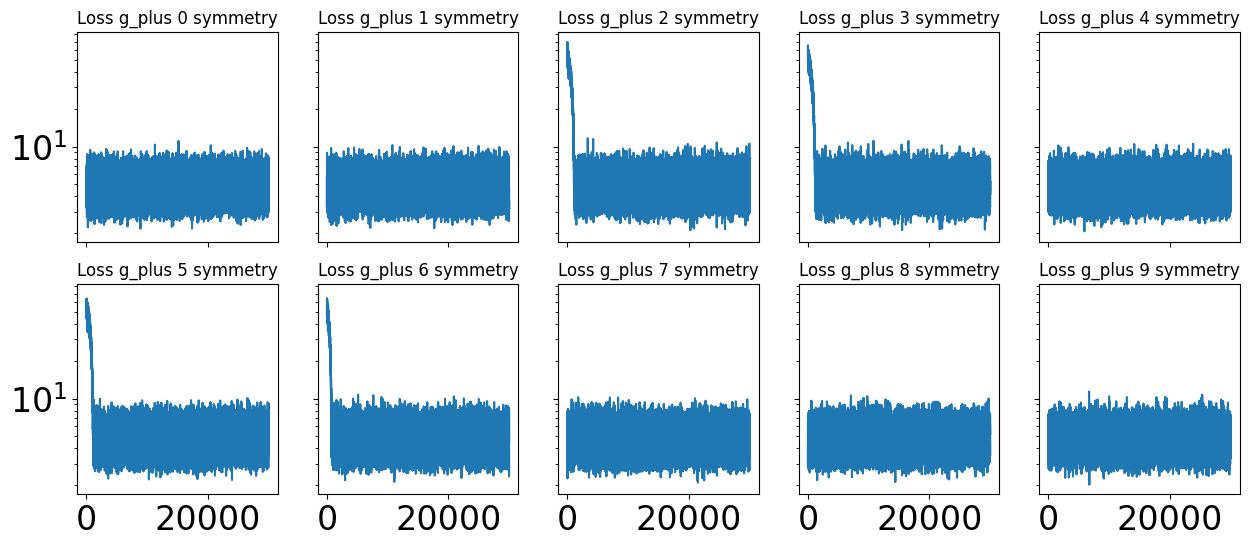

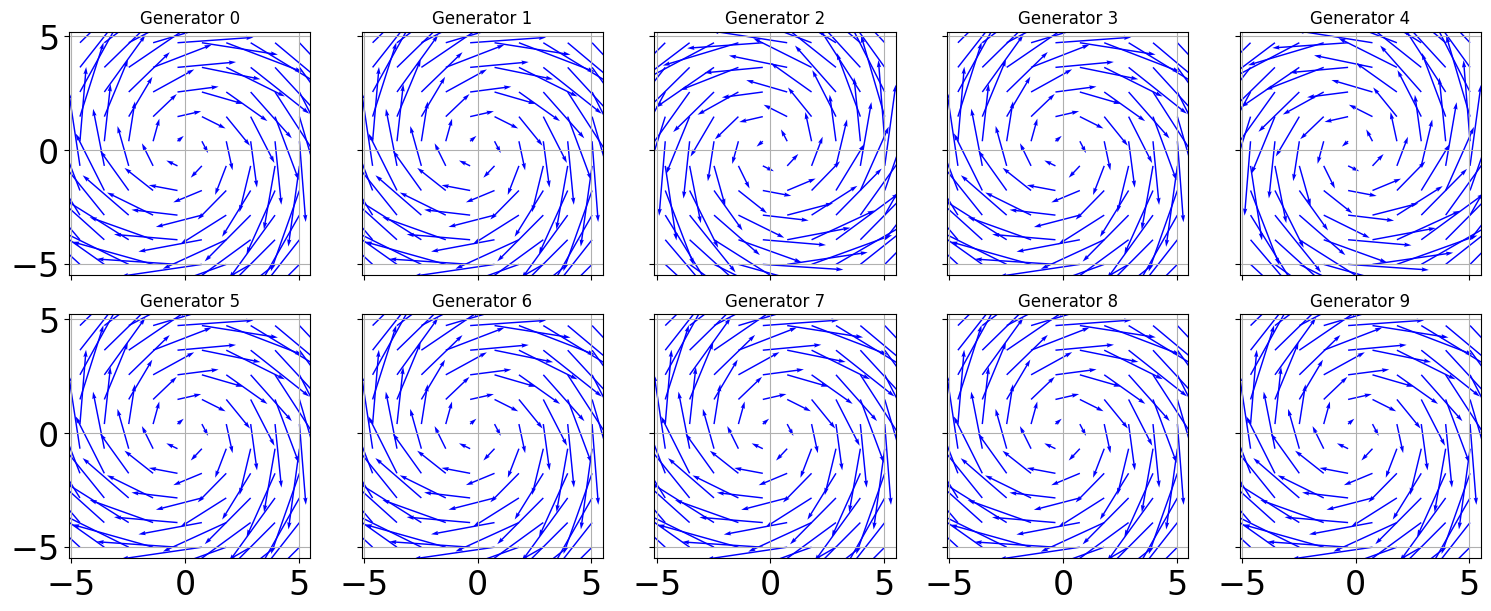

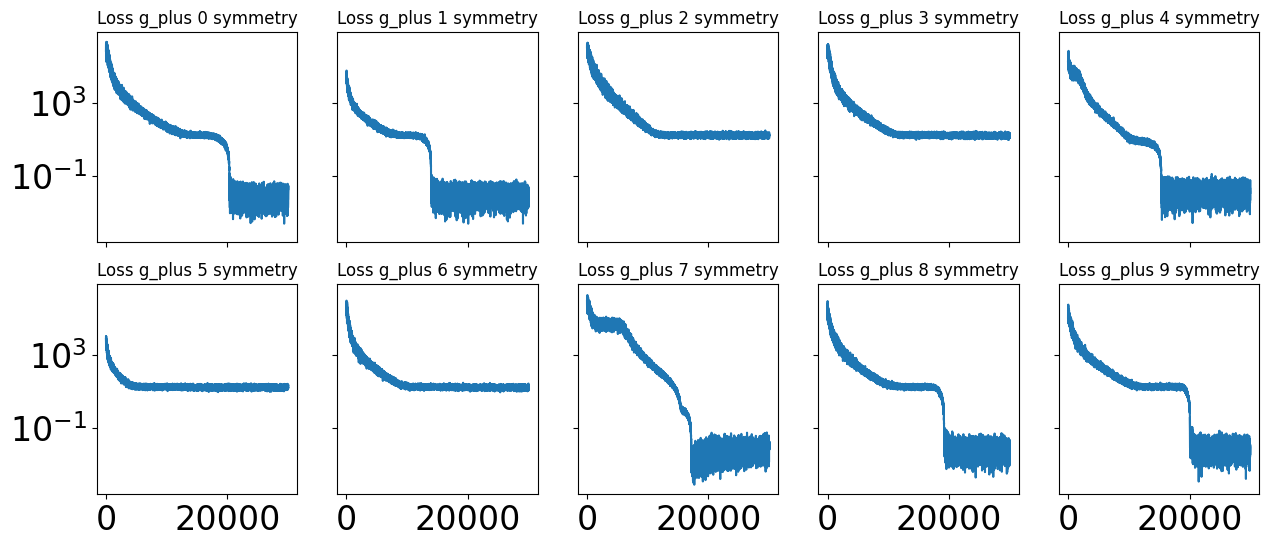

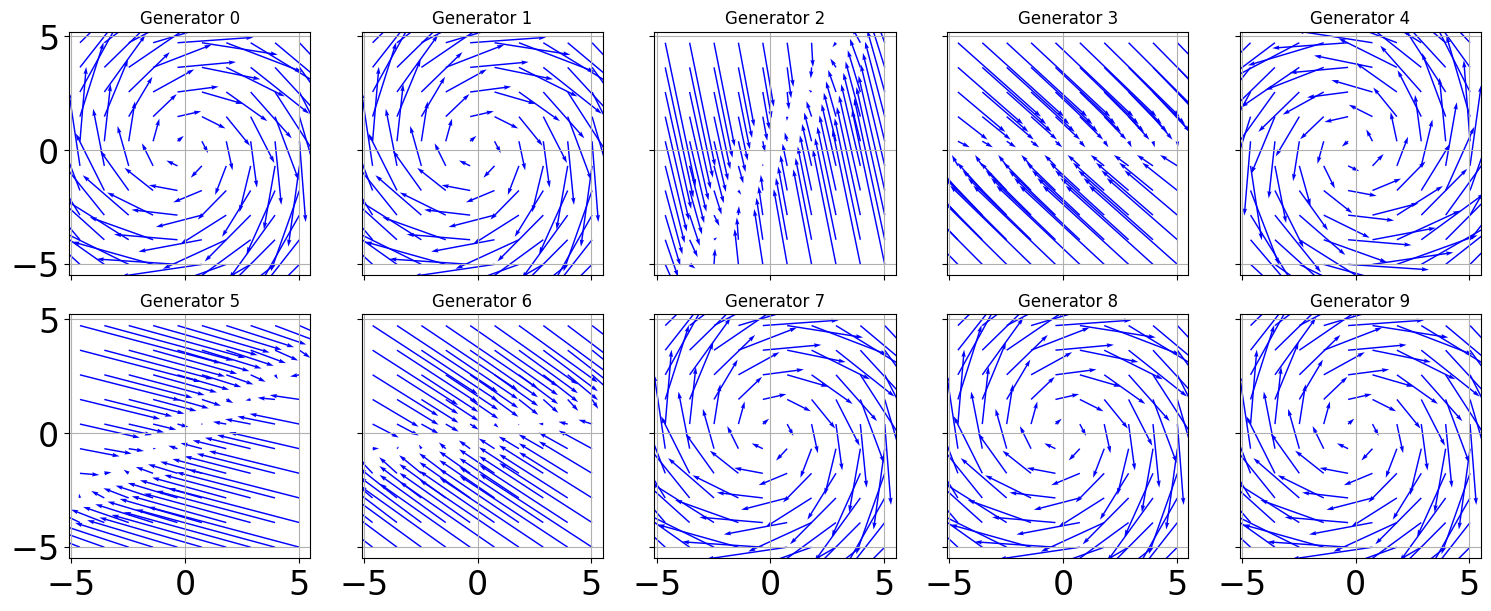

In [114]:
def plot_loss(generators):

    fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flat):
        ax.plot(generators[i]._losses)
        ax.set_title(f"Loss g_plus {i} symmetry")
        ax.set_yscale("log")

def plot_vector_field(generators):

    fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True, sharex= True, sharey=True)
    for i, ax in enumerate(axes.flat):
        plot_learned_generator(generators[i].g_norm, ax, title=f"Generator {i}", quiver_scale=1)

plot_loss(diff_generators)
plot_vector_field(diff_generators)

plot_loss(func_generators)
plot_vector_field(func_generators)